# Abstract

Every year (including once last week), highly endangered right whales are killed from human marine activity. To try to prevent this, some have proposed placing buoys in high traffic areas which listen for whales and automatically alert nearby vessels. For this to be feasible we must have accurate machine learning models that quickly identify whale sounds: the goal of this project. 

This project takes a dataset of 30,00 labeled two second hydrophone recoding’s from a Kaggle competition and runs three different ML models to try to identify if a whale was present in the recording.

All three techniques had reasonable performance, and both CNN models had greater than 90% performance, however the most complex CNN architecture stood out as have significantly lower false negative error rate, which is the most harmful form of error for this problem.

# Introduction

![News story about death taking place during final project](./src/news_story.png)

As hunting and environmental destruction decimates whale populations across the world, great strides must be taken to maximize the genetic diversity of many whale species. A major cause of whale death and disruption are commercial marine industry. To this end Marinexplore and Cornell University collected hydrophone recordings with and without whale calls in the North Atlantic. In 2013, Cornell University posted a competition for the most accurate models to distinguish whale calls from recordings. I wish to try solving this problem using the advances in machine learning in the last decade.

I used to work on a commercial ship in Washington state. While chatting with my ex-boss, he mentioned how interesting the proposed new Bremerton-Seattle ferry project was. The route would be made zero immersions by building a novel electric hydrofoil ferry. One of the major blockers to the project with the extremely endangered orca pods who would once every few years venture into Seattle's bay. Unlike traditional ferry's this project would be much faster, quieter, and effectively have a guillotine cutting through the water. The risk of killing one of the Orcas would be much higher than past project. So, some advocates proposed launching hydrophone buoys across the ferries route that would listen for the rare orca calls and signal the ferry to cut speed and avoid the pod. This would be a novel solution that would either require a huge amount of manual labor or require a novel machine learning algorithm to monitor the feeds. I found this challenge interesting and wish to take a crack at the problem.

![Three main goal of the project](./src/project_overview.png)

The challange is catagorizing audio clips (input), into whale present or no whale present (output). I will accoplish this goal by turning the audio clips into images, running K-NN, Using a off the shelf CNN (ResNet), then building my own CNN.


# Related Work
Either as part of the introduction or in a separate section, give a brief overview of how others have solved this problem. You don’t need to do a complete literature search, but you should briefly summarize the approach and results of any other work that you found that is tackling this or a similar problem.

Looking the the old leaderboard, competitors had the greatest success analyzing the spectrograms. This would allow me to treat the project as an image recognition task which seems to be common in the industry and more closely relates to the content of this class.


This compeition was run more than a decade ago, and the top performing teams used CNN on spectrograms of the audio. Looking the the old leaderboard, competitors had the greatest success analyzing the spectrograms. This would allow me to treat the project as an image recognition task which seems to be common in the industry and more closely relates to the content of this class. I found a computer scientist who did their capstone on solving this problem using LeNet-5, a model that was once the best CNN for classifying imageNet, before latter models like ResNet came along.

# Dataset

## About Source Data

Sourced from [The Marinexplore and Cornell University Whale Detection Challenge on Kaggle](https://www.kaggle.com/competitions/whale-detection-challenge), 
my dataset contained 30,000 two second audio files and an accopanied csv file with the labels. The audio files were all aiff sound clip with a sample rate of 2 kHz. The csv file contained the file name and the label. The label was a 1 if a whale was present in the audio file and a 0 if a whale was not present.

## Pre-processing

To take advantage of my in class learning, my first goal was to turn this audio catagorization problem into an image catagorization problem. I used LibRosa to convert the audio files into spectrograms. I then used the spectrograms as the input to my models. 

To see how I bulk converted the audio files into spectrograms, see my [github](https://github.com/levshuster/whale-detection), but here is an example of creating a single spectrogram from a single audio file.

This code is loosly based on [Transforming 2kHz .aiff Whale audio to .png](https://www.kaggle.com/code/diegoasuarezg/transforming-2khz-aiff-whale-audio-to-png) by Diego Suarez

In an effort to save space, I did not submit any of the original sound files, included in this submission is only the spectrograms. I have written a clear readme and helper function on my [github](https://github.com/levshuster/whale-detection) if you wish to load the original audio files.

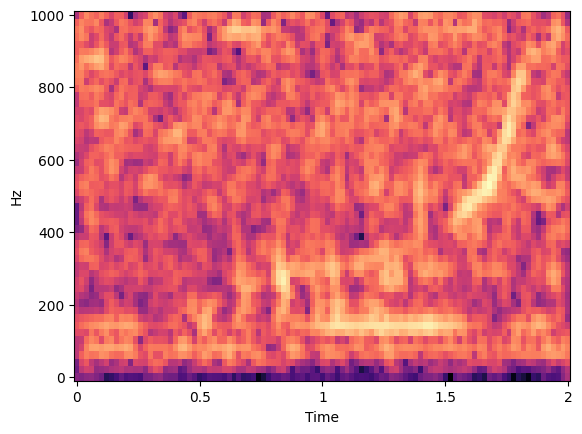

In [81]:
import librosa
import soundfile as sf
import numpy as np


audio_data, sample_rate = sf.read('./src/train1.aiff')
hl = 40

librosa.display.specshow(
	librosa.power_to_db(
		librosa.feature.melspectrogram(
			y=audio_data,
			sr=sample_rate,
			n_fft=200,
			hop_length=hl,
			n_mels=50,
			fmax=500
		), 
		ref=np.max
	),
	x_axis='time',
	y_axis='linear',
	sr=sample_rate,
	hop_length=hl, 
)

Above is an example of how I converted the audio files into spectrograms. The axis annd labels are not included in my actual processed image set.

The audio to image pre-processing step makes a few critical decisions including the max frequency and the resolution. I was able to confidantly pick these parameters by reivewing past published work relating to this dataset.

![Example whale images](./src/example_whale_images.png)

The goals of the CNNs are to identify the uptones (bent lines) only visible in the spectrograms of the whale calls.


I also re-processed the data to match Kerass's folder input structure. Because the orignal set of images are too large to include in this zip, to see all the code that I used to pre-process the data, see my [github](https://github.com/levshuster/whale-detection). The result are a colleciton of folders labeled by their training/testing split and number of images in each folder. See the `dataset` folder for an example. Lastly, I converted all the training images into one large numpy array and all the testing images into another large numpy array. Again, this work can be found on my github.

## Training, Validation and Testing

I used a 80/20 split for training and testing. I then used a 80/20 split to split the trainiing set into a training/validation set for the two CNN. To create a subset of the 30,000 I randomly pulled images from the total set. Each split is made randomly. Most of the results in this form are from a 11,000 sample subset (1/6th of the total dataset). This is the max dataset size that can acheive a 50/50 split of whale present audio recordings and whale not present audio recordings. When noted, I will also include results from the entire dataset or from a 200 sample subset.

# Methods

## K-Nearest Neighbors

### How it works

For my minimume viable product I rean K-Nearest Neighbors on the spectograms of whale sounds. K-Nearest Neighbors is one of the first supervised learning classifiers we discussed in class. It was also the first non-linear classifier we discussed. The algorithm works by comparing a audio clip it is trying to predict to every other audio clip in its training set. It selects some number (k) of the closest audio clips then returns which ever cataogory is most common among the k neighbors. I used scikit-learn's KNeighborsClassifier to run the model.

In an effort to speed up the classification proces, I used a KD Trees data structure which takes each image (represented as a point in high dimensional space) and organizes it into a 
[binary tree like structure](https://medium.com/smucs/a-look-into-k-dimensional-trees-290ec69dffe9)
that allows for faster searching.

### Variations

Below is the KNN class I used. You can see the availible parameters for variations in how I call the class. It has one hyper-parameter: the number of neibors to consider. I also varied the makeup of the dataset. Results for these variations can be found in the results section. 

In [82]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Class to allow saving of KNN models, caching of past predictions, and a way to programaticly vary the base model.
class KNN:
	last_fit_hash = None
	last_prediciton_hash = None
	last_prediction = None
	def __init__(self, n_neighbors, version, dataset_name, do_not_load=False):
		self.n_neighbors = n_neighbors
		self.version = version
		self.dataset_name = dataset_name
		self.do_not_load = do_not_load
		self.model = KNeighborsClassifier(
			n_neighbors=n_neighbors,
			n_jobs=-1,
			algorithm='kd_tree',
		)
		print(f'KNN model with {n_neighbors} neighbors created')

	def fit(self, x_train, y_train):
		x_train_hash = hash(x_train.tobytes())
		if x_train_hash == self.last_fit_hash:
			print('Last Fit Cached')
		else: 
			print(f'Fitting model with {len(x_train)} samples')
			self.last_fit_hash = x_train_hash
			self.model.fit(x_train, y_train)
		return self
	
	def predict(self, X):
		X_hash = hash(X.tobytes())
		if X_hash == self.last_prediciton_hash:
			print('Last Precition Cached')
		else:
			self.last_prediciton_hash = X_hash
			self.last_prediction = self.model.predict(X)
			self.save()
		return self.last_prediction
	
	def get_name(self):
		return f'./models/{self.n_neighbors}-nn_{self.version}_{self.dataset_name}.pkl'

	def save(self):
		print(f'Saving model {self.get_name()}')
		with open(self.get_name(), 'wb') as f:
			pickle.dump(self, f)
		return self
		
	def load(self):
		if self.do_not_load:
			print('Warning: do_not_load flag set to true, model will not be loaded from disk')
			return self
		try:
			with open(self.get_name(), 'rb') as f:
				print(f'Model {self.get_name()} loaded')
				return pickle.load(f)
		except:
			print(f'Warning: could not load model {self.get_name()}')
			return self

dataset_name = '5500'
# dataset_name = '200'
folder = f'./dataset/numpy/{dataset_name}-training/'

x_train = np.load(folder+'x_flatten.npy')
y_train = np.load(folder+'y.npy')

KNN(
	n_neighbors=1,
	version='0.3',
	dataset_name=dataset_name,
	do_not_load=False
)\
	.load()\
	.fit(x_train, y_train)\
	.save()

KNN model with 1 neighbors created
Model ./models/1-nn_0.3_5500.pkl loaded
Last Fit Cached
Saving model ./models/1-nn_0.3_5500.pkl


## ResNet

### How it works

For my main goal, I retrained ResNet, an off the shelf CNN to classify the images of whale sounds. ResNet made a name for itself by taking great strides to addres the issue of vanishing gradients (weights stop changing in deep neural networks because the chain rule in the loss function keeps returning zero). It does this by adding a "skip connection" that bypasses one or more layers. I used resnet 50 which uses zero padding, 12 layers of convolution, and Batch normilization. I used Keras's implementation of ResNet, and added my own output layer to match my two classes I wish to catagorize.

At the time of the competition, ResNet did not exists, so I did novel work. However a pre-pre-curser to ResNet, LeNet-5, was used in a published project submission with great results. Because both ResNet and LeNet-5 where trained on the same dataset (ImageNet) and are used in the same way (general purpose image categorization CNN that is retrained to specific tasks).

### Variations

Below is the ResNet CNN class I used. You can see the availible parameters for variations in how I call the class. It has two main hyper-parameter: learning rate and if it should initialize with random weights or ImageNet weights. I also varied the makeup of the dataset and the number of epochs to train for. Results for these variations can be found in the results section. 

In [83]:
import pickle
from tensorflow import keras 
from keras.optimizers.legacy import Adam
from tqdm import tqdm



class ResNet:
	last_prediciton_hash = None
	last_prediction = (None, None)
	epoch_counter = 0

	def __init__(self, learning_rate, use_weights:bool, version, dataset_name, do_not_load=False):
		self.version = version
		self.learning_rate = learning_rate
		self.use_weights = use_weights
		self.dataset_name = dataset_name
		self.do_not_load = do_not_load
		self.model = self.create_model(learning_rate, use_weights)
		
	def create_model(self, learning_rate, use_weights):
		resnet_model = keras.applications.ResNet50(include_top=False,
			input_shape=(224,224,3),
			pooling='avg',
			classes=2,
			weights='imagenet' if use_weights else None
		)
		model = keras.models.Sequential()
		model.add(resnet_model)
		model.add(keras.layers.Dense(2, activation='softmax'))
		model.compile(
			optimizer=Adam(learning_rate=learning_rate),
			loss='sparse_categorical_crossentropy',
			# loss='categorical_crossentropy',
			metrics=['accuracy']
		)
		print(model.summary())
		return model

	def fit(self, train_set, validation_set, additional_epochs):
		self.model.fit(
			train_set,
			validation_data=validation_set,
			epochs=additional_epochs
		)
		self.epoch_counter += additional_epochs
		self.last_prediciton_hash = None
		return self

	def predict(self, test_set, ignore_cache = False)->tuple:
		X_hash = hash(test_set)
		if ignore_cache == False and X_hash == self.last_prediciton_hash:
			print('Last Prediction Cached')
		else:
			self.last_prediciton_hash = X_hash
			self.last_prediction:tuple = self.get_y_pred_and_y(test_set)
			self.save()
		return self.last_prediction

	def get_y_pred_and_y(self, test_set)->tuple:
		predictions = []
		labels = []
		for x, y in tqdm(test_set):
			predictions.append(
				self.model.predict(
					x,
					verbose=0
				)
			)
			labels.append(y)

		labels_1d = []
		for label in labels:
			labels_1d.extend(label.numpy())
		labels_1d = np.array(labels_1d)

		predictions_1d = []
		for prediction in predictions:
			for p in prediction:
				predictions_1d.append(p)
		predictions_1d  = np.argmax(predictions_1d, axis=1)
		return (labels_1d, predictions_1d)
	
	def get_name(self, epochs):
		return f'./models/resnet_{self.version}_{self.dataset_name}_lr{self.learning_rate}_epoch{epochs}_weights{self.use_weights}.pkl'

	def save(self):
		print(f'Saving model {self.get_name(self.epoch_counter)}')
		with open(self.get_name(self.epoch_counter), 'wb') as f:
			pickle.dump(self, f)
		return self
		
	def load(self, epochs):
		if self.do_not_load:
			print('Warning: do_not_load flag set to true, model will not be loaded from disk')
			return self
		try:
			with open(self.get_name(epochs), 'rb') as f:
				print(f'Model {self.get_name(epochs)} loaded')
				return pickle.load(f)
		except:
			print(f'Warning: could not load model {self.get_name(epochs)}')
			return self
	
	def model_exists(self, epochs):
		try:
			with open(self.get_name(epochs), 'rb') as f:
				return True
		except:
			return False
	


In [84]:

dataset_name = '5500'
folder = f'./dataset/random-{dataset_name}-0.8/'

train_set, validation_set = [keras.preprocessing.image_dataset_from_directory(
	folder+'training/',
	validation_split=0.2,
	subset=i,
	seed=123,
	image_size=(224, 224),
	batch_size=32,
) for i in ["training", "validation"]]

ResNet(
	learning_rate=0.001,
	use_weights=False,
	version='0.1',
	dataset_name=dataset_name,
	do_not_load=False
)\
	.load(epochs=0)\
	# .fit(train_set, validation_set, additional_epochs=1)\
	# .save()

# one fitting epoch takes 10 minutes 

Found 11000 files belonging to 2 classes.
Using 8800 files for training.
Found 11000 files belonging to 2 classes.
Using 2200 files for validation.
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_52 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


## Simple Convolutional Neural Network

Describe your learning algorithms, including all variations. Please use relevant mathematical notation, and include a short description about how each algorithm works.

### How it works

For my stretch goal, I built my own CNN to classify the images of whale sounds. Based on your adivce I convolved my image until it was smaller than 10x10, then added two fulley connected layers using the ReLu activation function. I used Keras to implement my CNN, and added a output layer to match my two classes I wish to catagorize.

A Convolutional Neural Network has two main parts, the convolutional layers and the fully connected layers. The convolutional layers are made up of convoluitional layers that perturb the image to extract more general and useful features, the max pooling step decreases the breadth of the tensors to the convolutional layers don't make the tensor too big to use (and helps the NN focus on features rather than the raw pixel values). The fully connected layers are made up of nodes that are connected to every node in the previous layer, they take in a flattened tensor (the result of the convolutions).

### Variations

Below is the CNN class I used. You can see the availible parameters for variations in how I call the class. It has four main hyper-parameter: learning rate, number of convolutions, number of dense layers, number of nodes in each layer. However, Conversations with you encouraged me set some of these hyperparameters based on acitecture rather than testing with the validation set, meaning I did not tune all four hyper-parameters (example: you told me to just do enough convolutions to get a image of size less than 10x10 so once I reached that goal, I didn't do much further convolutional hyper-parameter turnning). I also varied the makeup of the dataset and the number of epochs to train for. Results for these variations can be found in the results section. 

In [85]:
class CNN:
	last_prediciton_hash = None
	last_prediction = (None, None)
	epoch_counter = 0

	def __init__(
			self, version, dataset_name, learning_rate = 0.001, 
			num_of_conv = 3, num_of_dense = 2, num_of_nodes = 64, 
			do_not_load=False):
		
		self.version = version
		self.learning_rate = learning_rate
		self.num_of_conv = num_of_conv
		self.num_of_dense = num_of_dense
		self.num_of_nodes = num_of_nodes
		self.dataset_name = dataset_name
		self.do_not_load = do_not_load
		self.model = self.create_model(learning_rate, num_of_conv, num_of_dense, num_of_nodes)
		
	def create_model(self, learning_rate, num_of_conv, num_of_dense, num_of_nodes):
		model = keras.models.Sequential()
		model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
		for _ in range(num_of_conv - 1):
			model.add(keras.layers.MaxPooling2D((3, 3)))
			model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
		model.add(keras.layers.MaxPooling2D((2, 2)))
		model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
		model.add(keras.layers.Flatten())
		for _ in range(num_of_dense):
			model.add(keras.layers.Dense(num_of_nodes, activation='relu'))
		model.add(keras.layers.Dense(2, activation='softmax'))
		model.compile(
			optimizer=Adam(learning_rate=learning_rate),
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy']
		)
		print(model.summary())
		return model

	def fit(self, train_set, validation_set, additional_epochs):
		self.model.fit(
			train_set,
			validation_data=validation_set,
			epochs=additional_epochs
		)
		self.epoch_counter += additional_epochs
		self.last_prediciton_hash = None
		return self

	def predict(self, test_set, ignore_cache = False)->tuple:
		X_hash = hash(test_set)
		if ignore_cache == False and X_hash == self.last_prediciton_hash:
			print('Last Prediction Cached')
		else:
			self.last_prediciton_hash = X_hash
			self.last_prediction:tuple = self.get_y_pred_and_y(test_set)
			self.save()
		return self.last_prediction

	def get_y_pred_and_y(self, test_set)->tuple:
		predictions = []
		labels = []
		for x, y in tqdm(test_set):
			predictions.append(
				self.model.predict(
					x,
					verbose=0
				)
			)
			labels.append(y)

		labels_1d = []
		for label in labels:
			labels_1d.extend(label.numpy())
		labels_1d = np.array(labels_1d)

		predictions_1d = []
		for prediction in predictions:
			for p in prediction:
				predictions_1d.append(p)
		predictions_1d  = np.argmax(predictions_1d, axis=1)
		return (labels_1d, predictions_1d)
	
	def get_name(self, epochs):
		return f'./models/cnn_{self.version}_{self.dataset_name}_lr{self.learning_rate}_epoch{epochs}_conv{self.num_of_conv}_dense{self.num_of_dense}_node{self.num_of_nodes}.pkl'

	def save(self):
		print(f'Saving model {self.get_name(self.epoch_counter)}')
		with open(self.get_name(self.epoch_counter), 'wb') as f:
			pickle.dump(self, f)
		return self
		
	def load(self, epochs):
		if self.do_not_load:
			print('Warning: do_not_load flag set to true, model will not be loaded from disk')
			return self
		try:
			with open(self.get_name(epochs), 'rb') as f:
				print(f'Model {self.get_name(epochs)} loaded')
				return pickle.load(f)
		except:
			print(f'Warning: could not load model {self.get_name(epochs)}')
			return self

In [86]:

dataset_name = '5500'
# dataset_name = '200'
folder = f'./dataset/random-{dataset_name}-0.8/'

train_set, validation_set = [keras.preprocessing.image_dataset_from_directory(
	folder+'training/',
	validation_split=0.2,
	subset=i,
	seed=123,
	image_size=(224, 224),
	batch_size=32,
) for i in ["training", "validation"]]

CNN(
	learning_rate=0.001,
	num_of_conv = 3, 
	num_of_dense = 2, 
	num_of_nodes = 64,
	version='0.1',
	dataset_name=dataset_name,
	do_not_load=False
)\
	.load(epochs=4)\
	.fit(train_set, validation_set, additional_epochs=1)\
	.save()

# one fitting epoch takes 40 seconds

Found 11000 files belonging to 2 classes.
Using 8800 files for training.
Found 11000 files belonging to 2 classes.
Using 2200 files for validation.
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 2

# Experiments and results
Describe the experiments that you ran, including specifics about what you were testing and why. For example, you might note that you considered feature sets X, Y, and Z, where you thought Y would lead to highest performance due to not enough information in X and likely overfitting in Z. Explain how you chose X, Y, and Z. For any hyperparameters, such as learning rate or batch size for stochastic gradient descent, describe how you chose the values you used. Describe your metrics for evaluating performance, such as accuracy, precision, recall, accuracy for a particular subgroup, etc. Make sure that your experiments and metrics are described in sufficient detail that they could be replicated by someone else. Describe your results and your interpretation for them (e.g., if Z outperforms both X and Y, what does that mean and why might that have occurred?). You should present your results in graphs and/or tables that clearly communicate the key findings to your reader; these graphs/tables should be clearly labeled, including legends and axis labels, and the font should be big enough to be legible on the screen without resizing. In your results, you’ll likely want to perform some error analysis, examining what kinds of errors your model makes.


## K-Nearest Neighbors

First I wanted to get a baseline accuracy for KNN so I loaded in the 11000 dataset. It took 40 minutes to run this KNN model on the testing set, so I decided to do further K-NN testing on a 200 sample subset. However I did get a baseline accuarcy of 78%, with a false negative rate of 8%. This is a decent showing from the K-Nearest Neightbors algorithm.

In [87]:
folder = f'./dataset/numpy/{dataset_name}-testing/'
x_test = np.load(folder+'x_flatten.npy')
y_test = np.load(folder+'y.npy')

y_pred = KNN(
	n_neighbors=1,
	version='0.3',
	dataset_name=dataset_name,
	do_not_load=False
).load().predict(x_test)


KNN model with 1 neighbors created
Model ./models/1-nn_0.3_5500.pkl loaded
Last Precition Cached


To make 2832 prediction on this partial dataset took fourty minutes. This means a fast computer would struggle to keep up with a single live streamed hydrophone suggesting that KNN may not be strong contender fo rthis problem (40min*60sec/2832predictions ~ 1 second per a prediction when run on a very fast computer).

Not only that, but a model trained on 11000 samples take up 15GB of memory. Again showing the limits of KNN on huge image datasets.
	

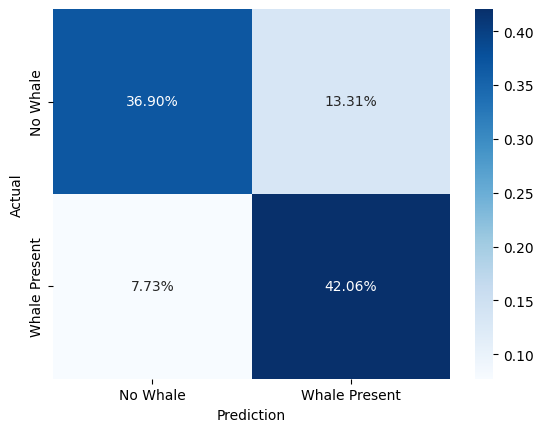

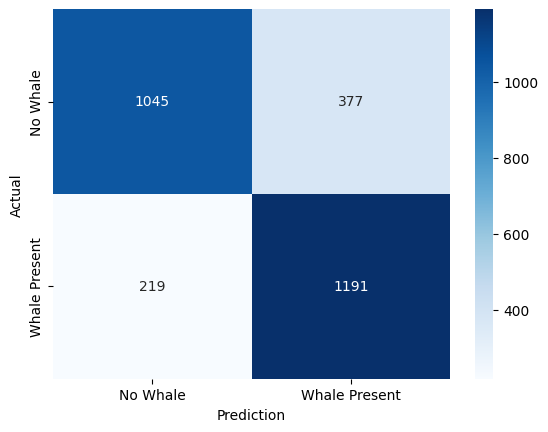

'Accuracy: 0.78954802259887'

In [88]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(y_true, y_pred, labels, normalize = False):
	cf_matrix = confusion_matrix(y_true, y_pred)
	sns.heatmap(
		cf_matrix if not normalize else cf_matrix/np.sum(cf_matrix), 
		annot=True,
		fmt='d' if not normalize else '.2%',
		xticklabels=labels,
		yticklabels=labels,
		cmap='Blues'
	).set(
		xlabel='Prediction',
		ylabel='Actual'
	)
	plt.show()

labels = ['No Whale','Whale Present']


confusion_matrix_plot(y_test, y_pred, labels, normalize = True)
confusion_matrix_plot(y_test, y_pred, labels, normalize = False)

def get_accuracy(y_test, y_pred):
	return np.sum(y_test == y_pred) / len(y_test)
f"Accuracy: {get_accuracy(y_test, y_pred)}"

Next I wished to tune the number of nearest neibors to consider.

In [103]:
dataset_name = '200'

folder = f'./dataset/numpy/{dataset_name}-testing/'
x_test = np.load(folder+'x_flatten.npy')
y_test = np.load(folder+'y.npy')

folder = f'./dataset/numpy/{dataset_name}-training/'
x_train = np.load(folder+'x_flatten.npy')
y_train = np.load(folder+'y.npy')

y_pred = [KNN(
	n_neighbors=i,
	version='1.0',
	dataset_name=dataset_name,
	do_not_load=False
).load().fit(x_train, y_train).save().predict(x_test) for i in range(1,15)]
accuracy = [get_accuracy(y_test, y) for y in y_pred]
accuracy

KNN model with 1 neighbors created
Model ./models/1-nn_1.0_200.pkl loaded
Last Fit Cached
Saving model ./models/1-nn_1.0_200.pkl
Last Precition Cached
KNN model with 2 neighbors created
Model ./models/2-nn_1.0_200.pkl loaded
Last Fit Cached
Saving model ./models/2-nn_1.0_200.pkl
Last Precition Cached
KNN model with 3 neighbors created
Model ./models/3-nn_1.0_200.pkl loaded
Last Fit Cached
Saving model ./models/3-nn_1.0_200.pkl
Last Precition Cached
KNN model with 4 neighbors created
Model ./models/4-nn_1.0_200.pkl loaded
Last Fit Cached
Saving model ./models/4-nn_1.0_200.pkl
Last Precition Cached
KNN model with 5 neighbors created
Model ./models/5-nn_1.0_200.pkl loaded
Last Fit Cached
Saving model ./models/5-nn_1.0_200.pkl
Last Precition Cached
KNN model with 6 neighbors created
Model ./models/6-nn_1.0_200.pkl loaded
Last Fit Cached
Saving model ./models/6-nn_1.0_200.pkl
Last Precition Cached
KNN model with 7 neighbors created
Model ./models/7-nn_1.0_200.pkl loaded
Last Fit Cached
Savi

[0.7551020408163265,
 0.7551020408163265,
 0.7653061224489796,
 0.8163265306122449,
 0.7857142857142857,
 0.8163265306122449,
 0.8163265306122449,
 0.8061224489795918,
 0.8061224489795918,
 0.8061224489795918,
 0.7959183673469388,
 0.7959183673469388,
 0.7959183673469388,
 0.7857142857142857]

[(0.72, 0.84)]

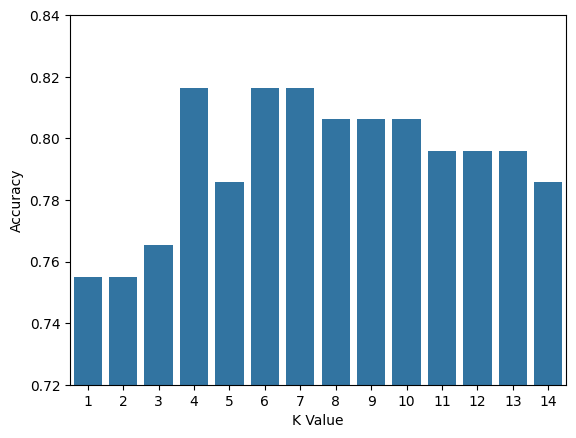

In [106]:
import pandas as pd
sns.barplot(
	pd.DataFrame({
		'Accuracy': accuracy,
		'K Value': range(1,15)
	}), 
	x="K Value", 
	y="Accuracy"
).set(
	ylim=(0.72, 0.84)
)

From this we conclude that 4-NN is the best number of neibors to consider.

![KNN on entire dataset](./src/KNN_on_entire_dataset.png)

Running this on the entire dataset we get the following resuls (not included here because the entire data set is too large to include in this zip). The accuracy is 92.42% and the false negative rate is 5.61%. This is a great showing from the K-Nearest Neightbors algorithm. However, 90% of all recordings didn’t contain a whale. Meaning that if I gave you an algorithm that just always said no whale is present, that idiotic model would only be 2% worse than KNN.

More fair is to again run 4-NN on the even split between whale present and whale not present audio recordings. 

![KNN on even dataset](./src/KNN_on_even_dataset.png)

Here we get 81% accuracy, but a not terribly false negative rate. This is a decent showing from the K-Nearest Neightbors algorithm.

## ResNet

First I wanted to get a base line accuracy for ResNet so I loaded in the 11000 dataset.

Found 2832 files belonging to 2 classes.
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_65 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None
Model ./models/resnet_0.1_5500_lr0.001_epoch1_weightsFalse.pkl loaded


100%|██████████| 89/89 [01:04<00:00,  1.38it/s]


Saving model ./models/resnet_0.1_5500_lr0.001_epoch1_weightsFalse.pkl


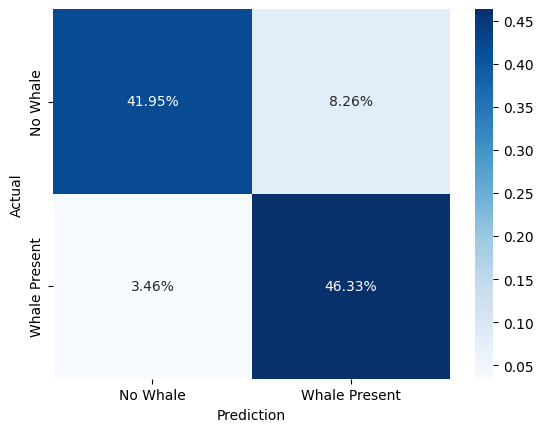

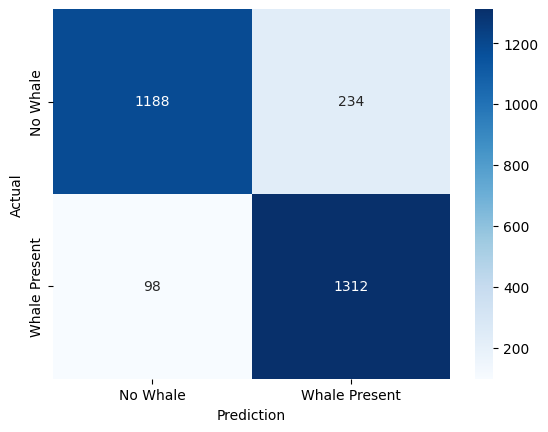

'Accuracy: 0.882768361581921'

In [107]:

dataset_name = '5500'
folder = f'./dataset/random-{dataset_name}-0.8/'

testing_set = keras.preprocessing.image_dataset_from_directory(
	folder+'testing/',
	image_size=(224, 224),
	batch_size=32,
)


labels_1d, predictions_1d = ResNet(
	learning_rate=0.001,
	use_weights=False,
	version='0.1',
	dataset_name=dataset_name,
	do_not_load=False
).load(epochs=1).predict(testing_set)

confusion_matrix_plot(labels_1d, predictions_1d, labels, normalize = True)
confusion_matrix_plot(labels_1d, predictions_1d, labels, normalize = False)

def get_accuracy(y_test, y_pred):
	return np.sum(y_test == y_pred) / len(y_test)
f"Accuracy: {get_accuracy(labels_1d, predictions_1d)}"

Here 2832 predictions only took a minute, plenty fast to be used in the real world. And immediatly, a unfine tuned ResNet model got 10% better performance than KNN. This is a great showing from the ResNet algorithm.

In [108]:
model = ResNet(
	learning_rate=0.001,
	use_weights=False,
	version='0.1',
	dataset_name=dataset_name,
	do_not_load=False
).load(epochs=1)
if False: # train model for 6 more epochs, saving each epoch, set to true if you want to retrain saved models but this will take roughlty an hour
	for _ in range(6): model.fit(train_set, validation_set, additional_epochs=1).save()

accuracy_x_epochs = [get_accuracy( *model.load(epochs = i).predict(testing_set)) for i in range(1,7)]
accuracy_x_epochs

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_66 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None
Model ./models/resnet_0.1_5500_lr0.001_epoch1_weightsFalse.pkl loaded
Model ./models/resnet_0.1_5500_lr0.001_epoch1_weightsFalse.pkl loaded
Last Prediction Cached
Model ./models/resnet_0.1_5500_lr0.001_epoch2_weightsFalse.pkl loaded


100%|██████████| 89/89 [01:02<00:00,  1.43it/s]


Saving model ./models/resnet_0.1_5500_lr0.001_epoch2_weightsFalse.pkl
Model ./models/resnet_0.1_5500_lr0.001_epoch3_weightsFalse.pkl loaded


100%|██████████| 89/89 [01:02<00:00,  1.43it/s]


Saving model ./models/resnet_0.1_5500_lr0.001_epoch3_weightsFalse.pkl
Model ./models/resnet_0.1_5500_lr0.001_epoch4_weightsFalse.pkl loaded


100%|██████████| 89/89 [01:01<00:00,  1.44it/s]


Saving model ./models/resnet_0.1_5500_lr0.001_epoch4_weightsFalse.pkl
Model ./models/resnet_0.1_5500_lr0.001_epoch5_weightsFalse.pkl loaded


100%|██████████| 89/89 [01:02<00:00,  1.42it/s]


Saving model ./models/resnet_0.1_5500_lr0.001_epoch5_weightsFalse.pkl
Model ./models/resnet_0.1_5500_lr0.001_epoch6_weightsFalse.pkl loaded


100%|██████████| 89/89 [01:03<00:00,  1.40it/s]


Saving model ./models/resnet_0.1_5500_lr0.001_epoch6_weightsFalse.pkl


[0.882768361581921,
 0.8467514124293786,
 0.8693502824858758,
 0.885593220338983,
 0.8862994350282486,
 0.8848870056497176]

[(0.8, 0.9)]

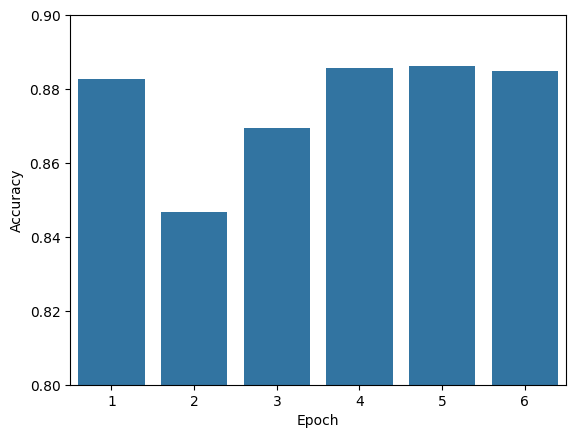

In [92]:
import pandas as pd
sns.barplot(
	pd.DataFrame({
		'Accuracy': accuracy_x_epochs,
		'Epoch': range(1,7)
	}), 
	x="Epoch", 
	y="Accuracy"
).set(
	ylim=(0.8, 0.90)
)

This shows that Four epochs is a sweet spot for ResNet.

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_67 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None
Model ./models/resnet_0.1_5500_lr0.001_epoch4_weightsFalse.pkl loaded
Last Prediction Cached


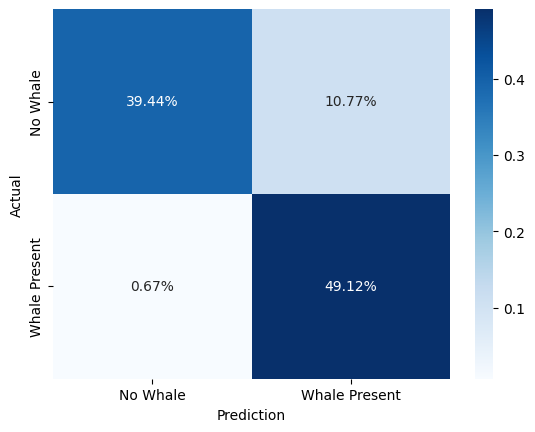

'accuracy: 0.885593220338983'

In [109]:
labels_1d, predictions_1d = ResNet(
	learning_rate=0.001,
	use_weights=False,
	version='0.1',
	dataset_name=dataset_name,
	do_not_load=False
).load(epochs=4).predict(testing_set)
confusion_matrix_plot(labels_1d, predictions_1d, labels, normalize = True)
f"accuracy: {get_accuracy(labels_1d, predictions_1d)}"

TODO: optimize the learning rate
TODO: show that using weights of resnet had no impact

With a 89% accuracy, and a false negative rate 1/6th of K-NN, ResNet is the better model for this dataset.

With nearly an identical accuracy rate on the entire dataset, ResNet had clearly found some generalizable features in the dataset.

## Simple Convolutional Neural Network

First I wanted to get a baseline accuracy for my CNN so I loaded in the 11000 dataset.

In [94]:
model = CNN(version='0.1', dataset_name=dataset_name,).load(epochs=1)
if True:
	for _ in range(15): model.fit(train_set, validation_set, additional_epochs=1).save()

accuracy_x_epochs = [get_accuracy( *model.load(epochs = i).predict(testing_set)) for i in range(1,15)]
accuracy_x_epochs

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 11, 11, 64)      

100%|██████████| 89/89 [00:06<00:00, 12.75it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch1_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch2_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.05it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch2_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch3_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 12.82it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch3_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch4_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.48it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch4_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch5_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.32it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch5_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch6_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.50it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch6_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch7_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.44it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch7_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch8_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.58it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch8_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch9_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.19it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch9_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch10_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.50it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch10_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch11_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.42it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch11_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch12_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.38it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch12_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch13_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.54it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch13_conv3_dense2_node64.pkl
Model ./models/cnn_0.1_5500_lr0.001_epoch14_conv3_dense2_node64.pkl loaded


100%|██████████| 89/89 [00:06<00:00, 13.27it/s]

Saving model ./models/cnn_0.1_5500_lr0.001_epoch14_conv3_dense2_node64.pkl


[0.868997175141243,
 0.8905367231638418,
 0.89795197740113,
 0.9011299435028248,
 0.8983050847457628,
 0.9050141242937854,
 0.8997175141242938,
 0.9050141242937854,
 0.903954802259887,
 0.9060734463276836,
 0.89795197740113,
 0.890183615819209,
 0.9004237288135594,
 0.8940677966101694]

My sipmle CNN was much faster than Resnet, in the time it took resnet to do a single epoch, my CNN could do 15


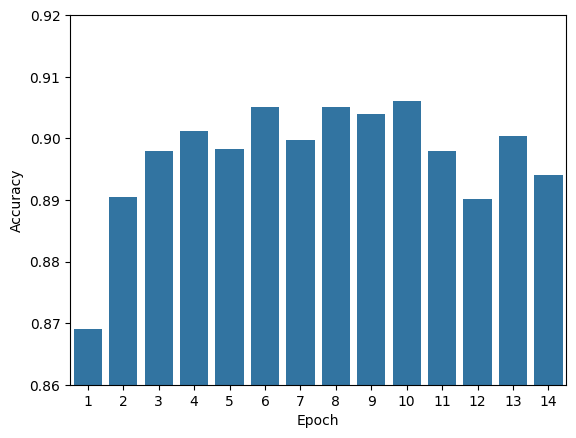

In [95]:
_ = sns.barplot(
	pd.DataFrame({
		'Accuracy': accuracy_x_epochs,
		'Epoch': range(1,15)
	}), 
	x="Epoch", 
	y="Accuracy"
).set(
	ylim=(0.86, 0.92)
)

6 Epochs seemed like a sweet spot for my CNN.

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 11, 11, 64)      

100%|██████████| 89/89 [00:06<00:00, 13.48it/s]


Saving model ./models/cnn_0.1_5500_lr0.001_epoch6_conv3_dense2_node64.pkl


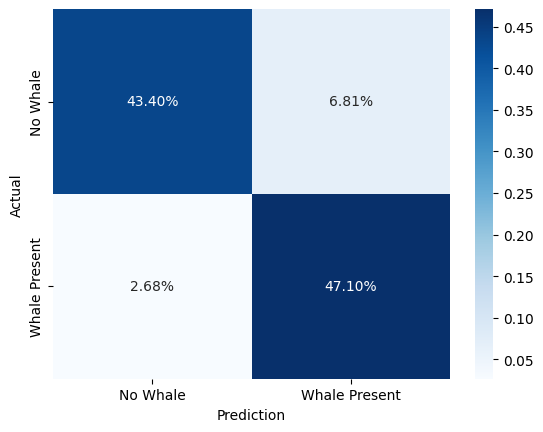

'accuracy: 0.9050141242937854'

In [110]:
labels_1d, predictions_1d = CNN(version='0.1', dataset_name=dataset_name,
).load(epochs=6).predict(testing_set)
confusion_matrix_plot(labels_1d, predictions_1d, labels, normalize = True)
f"accuracy: {get_accuracy(labels_1d, predictions_1d)}"

In [97]:
# from sklearn import metrics
# y = labels_1d
# pred = predictions_1d
# fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
# metrics.auc(fpr, tpr)

from sklearn.metrics import roc_auc_score
print('AUC: %.3f' % roc_auc_score(labels_1d, predictions_1d))
f"accuracy is {get_accuracy( labels_1d, predictions_1d)}"


AUC: 0.905


'accuracy is 0.9050141242937854'

# Discussion and future work
Briefly summarize your project and results, emphasizing the key findings and takeaways. Discuss any overarching themes about what performed best and why, and/or what you learned from the project. If you had additional time or resources, what next steps would you want to explore, and what new questions have been raised by your investigation? Are there any particular impacts that your project (or solution to the problem you’re investigating) could have on society, and are there any ethical concerns that are brought up by your problem, approach, or results?